In [2]:
import pandas as pd
import numpy as np   
import matplotlib.pyplot as plt

In [3]:
def mm_cross_simple(df,col_price,mm_short,mm_long):
    mm_short_name = str(mm_short) + 'MA'
    mm_long_name = str(mm_long) + 'MA'
    signal_mm = mm_short_name + mm_long_name
    df[mm_short_name] = df[col_price].rolling(window=mm_short).mean()
    df[mm_long_name] = df[col_price].rolling(window=mm_long).mean()
    df[signal_mm] = np.where(df[mm_short_name] > df[mm_long_name], 1,-1)
    return df

In [7]:
wd_input = '/Users/alexandrucristiean/Desktop/Pascal_C/'
df = pd.read_csv('{}/sample_data.csv'.format(wd_input),delimiter = ',')   #price data

In [8]:
def return_cum_strat_last_el(df, mm_short_arg, mm_long_arg,mm_short1,mm_long2):
    mm_short = mm_short_arg
    mm_long = mm_long_arg
    
    #col title in the df
    signal_ma = str(mm_short) + 'MA' + str(mm_long) + 'MA'
    signal_ma1 = str(mm_short1) + 'MA' + str(mm_long2) + 'MA'
    tc = .002      #transaction costs 0.05%
    
    df['price'] = df['price'].astype(float)
    df['date'] = df['time']/1000                      #binance time is in milliseconds-> transform in seconds
    df['date'] = pd.to_datetime(df['date'], unit='s') #format binance date in readable date 

    #signal calcul
    df = mm_cross_simple(df,'price',mm_short,mm_long)     #add in df above: short_ma, long_ma, signal_mm
    df = mm_cross_simple(df,'price',mm_short1,mm_long2)   #add in df above: short_ma, long_ma, signal_mm
    
    df['signal'] = df[signal_ma] + df[signal_ma1]                              #create df signal: sell if -1 and buy if +1
    df['signal_chg'] = np.where(df['signal'] != df['signal'].shift(1), 1,0)    #count signal change, then number of trades
    df['tc'] = df['signal_chg'] * tc                                           #calc transactions cost
    df['tc'] = df['tc'].cumsum()
    
    #return calculations
    df['return'] = (df['price'] / df['price'].shift(1))-1                      #calc returns per minute for the series
    df['cum_return'] = (1 + df['return']).cumprod() - 1                        #calc cumulated returns for the series
    df['strat_ret'] = df['return'] * df ['signal']                             #calc strategy returns per minute for the series
    df['cum_strat_ret'] = (1 + df['strat_ret']).cumprod() - 1                  #calc strategy cumulated returns
    df['cum_strat_ret_tc'] = df['cum_strat_ret'] - df['tc']                    #remove transactions costs

    df.plot(x = 'date', y='cum_strat_ret_tc')                                  #graph the strategy returns 
    
    return df['cum_strat_ret_tc'].iloc[-1]                     # last element of Series df[..]

-2.6023117135803493

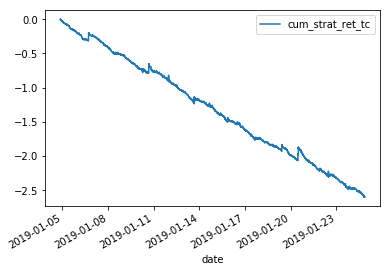

In [9]:
return_cum_strat_last_el(df, 100, 500, 5, 20)

In [ ]:
a_dict = {}
short_values = []
long_values = []
cum_strat_values = []

for short in range(2,101):
    for long in range(5,201):
        if short < long and long-short < 7:
            last_cum_strat_value = return_cum_strat_last_el(df, short, long)
            
            short_values.append(short)
            long_values.append(long)
            cum_strat_values.append(last_cum_strat_value)
            
            a_dict[last_cum_strat_value] = (short, long)
            
            print("short:{}, long:{}, last_el_df_cum_strat:{}".format(short, long, last_cum_strat_value))

In [7]:
print("The highest cum_strat_value is {}, with mm_short={} and mm_long={}".format(max(a_dict),
                                                                                 a_dict[max(a_dict)][0],
                                                                                 a_dict[max(a_dict)][1]))

The highest cum_strat_value is 45.48206077314666, with mm_short=2 and mm_long=5
